<a href="https://colab.research.google.com/github/ebudd45/Meteorologyclass/blob/main/stormofthecentury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#Magic to make Cartopy work
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -q -c conda-forge cartopy
import cartopy
cartopy.__version__

✨🍰✨ Everything looks OK!


'0.21.1'

In [23]:
#!mamba install -q -c conda-forge cartopy

In [24]:
#import cartopy
#cartopy.__version__

In [25]:
#Install needed modules
!pip install metpy
!pip install cartopy
!pip install siphon
!pip install netcdf4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
#Import needed modules
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
from metpy.plots import StationPlot
from metpy.units import units
from netCDF4 import Dataset, num2date
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog

In [44]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 12

dt = datetime(year, month, day, hour)

In [45]:
# Read NARR Data from THREDDS server
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/'

# Programmatically generate the URL to the day of data we want
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')

# Have Siphon find the appropriate dataset
ds = cat.datasets.filter_time_nearest(dt)

# Interface with the data through the NetCDF Subset Service (NCSS)
ncss = ds.subset()

# Create an NCSS query with our desired specifications
query = ncss.query()
query.lonlat_box(north=60, south=18, east=300, west=225)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

# Use the query to obtain our NetCDF data
data = ncss.get_data(query)

In [46]:
# Back up in case of bad internet connection.
# Uncomment the following line to read local netCDF file of NARR data
# data = Dataset('../../../data/NARR_19930313_0000.nc','r')

In [47]:
data.dimensions

{'time1': <class 'netCDF4._netCDF4.Dimension'>: name = 'time1', size = 1,
 'isobaric1': <class 'netCDF4._netCDF4.Dimension'>: name = 'isobaric1', size = 29,
 'y': <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 119,
 'x': <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 268}

In [48]:
# Extract data and assign units
tmpk = gaussian_filter(data.variables['Temperature_isobaric'][0],
                       sigma=1.0) * units.K
hght = gaussian_filter(data.variables['Geopotential_height_isobaric'][0],
                       sigma=1.0) * units.meter
uwnd = gaussian_filter(data.variables['u-component_of_wind_isobaric'][0], sigma=1.0) * units('m/s')
vwnd = gaussian_filter(data.variables['v-component_of_wind_isobaric'][0], sigma=1.0) * units('m/s')

# Extract coordinate data for plotting
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev = data.variables['isobaric1'][:]

In [49]:
#Extract time
time = data.variables['time1']
print(time.units)
vtime = num2date(time[0], units=time.units)
print(vtime)

Hour since 1993-03-13T12:00:00Z
1993-03-13 12:00:00


In [50]:
# Calcualte dx and dy for calculations
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

In [51]:
# Specify 850 hPa data
ilev850 = np.where(lev == 850)[0][0]
hght_850 = hght[ilev850]
tmpk_850 = tmpk[ilev850]
uwnd_850 = uwnd[ilev850]
vwnd_850 = vwnd[ilev850]

# Specify 500 hPa data
ilev500 = np.where(lev == 500)[0][0]
hght_500 = hght[ilev500]
uwnd_500 = uwnd[ilev500]
vwnd_500 = vwnd[ilev500]

# Specify 300 hPa data
ilev300 = np.where(lev == 300)[0][0]
hght_300 = hght[ilev300]
uwnd_300 = uwnd[ilev300]
vwnd_300 = vwnd[ilev300]

In [52]:
# Temperature Advection
tmpc_adv_850 = mpcalc.advection(tmpk_850, uwnd_850, vwnd_850, dx=dx, dy=dy)

In [53]:
# Planetary Vorticity
f = mpcalc.coriolis_parameter(np.deg2rad(lat)).to('1/s')

# Relative Vorticity
vor_500 = mpcalc.vorticity(uwnd_500, vwnd_500, dx=dx, dy=dy)

# Abosolute Vorticity
avor_500 = vor_500 + f

In [54]:
# Vorticity Advection
f_adv = mpcalc.advection(f, uwnd_500, vwnd_500, dx=dx, dy=dy)

relvort_adv = mpcalc.advection(vor_500, uwnd_500, vwnd_500, dx=dx, dy=dy)

absvort_adv = mpcalc.advection(avor_500, uwnd_500, vwnd_500, dx=dx, dy=dy)

In [55]:
# Stretching Vorticity
div_500 = mpcalc.divergence(uwnd_500, vwnd_500, dx=dx, dy=dy)

stretch_vort = -1 * avor_500 * div_500

In [56]:
#

In [57]:
# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100., central_latitude=40.,
                                 standard_parallels=[30, 60])

In [58]:
def create_map_background():
    fig=plt.figure(figsize=(14, 12))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-125, -73, 25, 50],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=0.75)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    return fig, ax

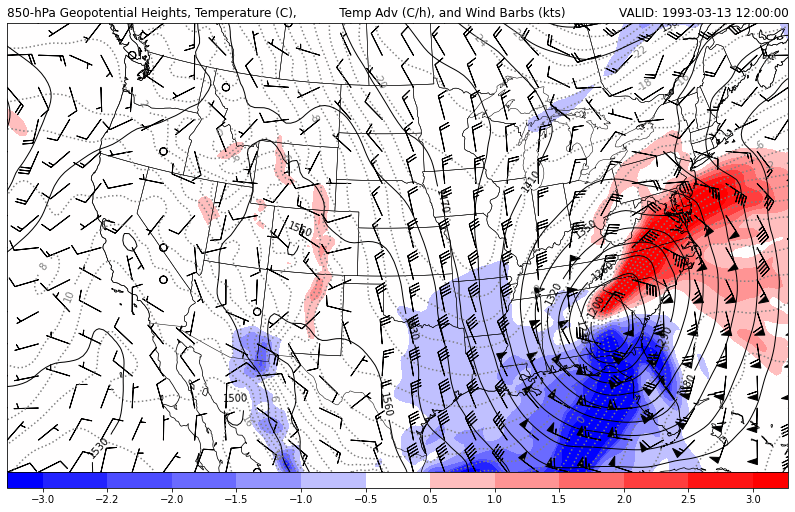

In [59]:
#Plot temperature advection
fig, ax = create_map_background()

# Contour 1 - Temperature, dotted
cs2 = ax.contour(lon, lat, tmpk_850.to('degC'), range(-50, 50, 2),
                 colors='grey', linestyles='dotted', transform=dataproj)

plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour 2
clev850 = np.arange(0, 4000, 30)
cs = ax.contour(lon, lat, hght_850, clev850, colors='k',
                linewidths=1.0, linestyles='solid', transform=dataproj)

plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Filled contours - Temperature advection
contours = [-3, -2.2, -2, -1.5, -1, -0.5, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
cf = ax.contourf(lon, lat, tmpc_adv_850*3600, contours,
                 cmap='bwr', extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50,
             extendrect=True, ticks=contours)

# Vector
ax.barbs(lon, lat, uwnd_850.to('kts').m, vwnd_850.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('850-hPa Geopotential Heights, Temperature (C), \
          Temp Adv (C/h), and Wind Barbs (kts)', loc='left')
plt.title(f'VALID: {vtime}', loc='right')

plt.show()

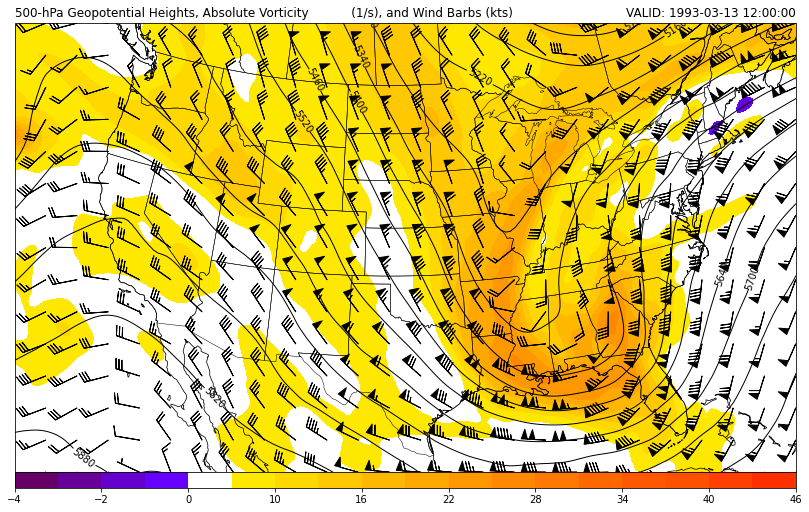

In [60]:
#Plot vorticity
fig, ax = create_map_background()

# Contour 1
clev500 = np.arange(0, 7000, 60)
cs = ax.contour(lon, lat, hght_500, clev500, colors='k',
                linewidths=1.0, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=4,
           fmt='%i', rightside_up=True, use_clabeltext=True)

# Filled contours
# Set contour intervals for Absolute Vorticity
clevavor500 = [-4, -3, -2, -1, 0, 7, 10, 13, 16, 19,
               22, 25, 28, 31, 34, 37, 40, 43, 46]

# Set colorfill colors for absolute vorticity
# purple negative
# yellow to orange positive
colorsavor500 = ('#660066', '#660099', '#6600CC', '#6600FF',
                 '#FFFFFF', '#ffE800', '#ffD800', '#ffC800',
                 '#ffB800', '#ffA800', '#ff9800', '#ff8800',
                 '#ff7800', '#ff6800', '#ff5800', '#ff5000',
                 '#ff4000', '#ff3000')

cf = ax.contourf(lon, lat, avor_500 * 10**5, clevavor500,
                 colors=colorsavor500, transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Vector
ax.barbs(lon, lat, uwnd_500.to('kts').m, vwnd_500.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title('500-hPa Geopotential Heights, Absolute Vorticity \
          (1/s), and Wind Barbs (kts)', loc='left')
plt.title(f'VALID: {vtime}', loc='right')

plt.show()